# Background
- Testing linear multi-class classifiers from course homework
- Try out multi-class softmax and multi-class perceptron cost functions
- Also play around with weighting based on number of events in each class (avoid overfitting 0 bubbles and poor fit on >0 bubbles)

In [1]:
from sys import getsizeof
from autograd import grad, hessian
from autograd.misc.flatten import flatten_func
import autograd.numpy as np
import pickle as pkl
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 8)

In [2]:
plotdir = "../bubbleimages/plots/"

# Cost Functions

In [3]:
# compute linear combination of input point
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

def multiclass_softmax_weighted(w, x, y, betas, lam=1e-5):
    # pre-compute predictions on all points
    all_evals = model(x,w)
    
    # compute maximum across data points
    a = np.log(np.sum(np.exp(all_evals), axis=0))# np.max(all_evals, axis=0)
    
    # compute cost in compact form using numpy broadcasting
    b = all_evals[y.astype(int).flatten(), np.arange(np.size(y))]
    cost = np.sum(betas*(a - b))
    
    # add regularizer
    cost += lam*np.linalg.norm(w[1:,:])**2
    
    # return average
    return cost #/ float(np.size(y))

# Descent Functions

In [4]:
def balanced_accuracy(y, y_model):
    N_class = int(np.max(y) + 1)
    accuracies = []
    for y_ in range(N_class):
        accuracies.append(np.sum((y == y_) & (y_model == y_)))
    accuracies = np.array(accuracies)
    return np.mean(accuracies)

In [5]:
def gradient_descent_class(g, alpha, max_its, w, x, y):
    """
    g: function to minimize value of
    alpha: step size
    max_its: maximum number of iterations
    w: starting weights (often randomized)
    """
    # create gradient calculator function for input function
    gradient = grad(g)
    # initial conditions calculations
    weight_history = [w] # weight history container
    cost_history = [g(w)] # cost function history container
    y_model = np.argmax(model(x, w), axis=0)[np.newaxis, :]
    misclass_history = [np.sum(y_model != y)]
    balanced_acc_history = [balanced_accuracy(y, y_model)]
    # gradient descent loop
    # (with progress bar using tqdm)
    for k in tqdm(range(max_its), desc="gradient step iteration"):
        # eval gradient
        grad_eval = gradient(w)
        # gradient descent step
        w = w - alpha*grad_eval
        # record weight, cost, misclassifications, balanced accuracy
        weight_history.append(w)
        cost_history.append(g(w))
        y_model = np.argmax(model(x, w), axis=0)[np.newaxis, :]
        misclass_history.append(np.sum(y_model != y))
        balanced_acc_history.append(balanced_accuracy(y, y_model))
    
    return (np.array(weight_history), np.array(cost_history), 
            np.array(misclass_history), np.array(balanced_acc_history))

# Classification Run Function

In [6]:
def plot_cost_misclass_history(it_num, ch, mch, cost_func, weighted, alpha, y):
    if weighted:
        wstr = ", Weighted"
        wstr2 = "_weighted"
    else:
        wstr = ""
        wstr2 = ""
    N_class = int(np.max(y) + 1)
    fname = cost_func+wstr2+f"_{N_class}class"
    # figure setup
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(f'History Plots: Multiclass {cost_func.capitalize()}{wstr}\n'+r'$\alpha =$'+f'{alpha:.4f}')
    ax1.plot(it_num, ch, marker='o', markersize=2)
    ax1.set_xlabel("Iteration Number")
    ax1.set_ylabel(r'g(w)')
    ax2.plot(it_num, mch, marker='o', markersize=2)
    ax2.set_xlabel("Iteration Number")
    ax2.set_ylabel("Number of misclassifications")
    fig.tight_layout(rect=[0, 0, 1, 0.9])
    fig.savefig(plotdir+"history_plots_"+fname+".pdf")
    fig.savefig(plotdir+"history_plots_"+fname+".png")

    return fig, ax1, ax2

In [7]:
def plot_confusion_matrix(y, y_model, cost_func, weighted, alpha):
    if weighted:
        wstr = ", Weighted"
        wstr2 = "_weighted"
    else:
        wstr = ""
        wstr2 = ""
    N_class = int(np.max(y) + 1)
    fname = cost_func+wstr2+f"_{N_class}class"
    # create zeros matrix of correct size
    mat = np.zeros((N_class, N_class))
    # construct confusion matrix
    for i in range(N_class):
        for j in range(N_class):
            mat[i, j] = np.sum((y == i) & (y_model == j))
    mat_norm = mat / np.sum(mat, axis=1).reshape(N_class, 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(f'Confusion Matrix: Multiclass {cost_func.capitalize()}{wstr}\n'+r'$\alpha =$'+f'{alpha:.4f}')
    ax1.matshow(mat)
    ax2.matshow(mat_norm)
    # add text to each square
    for (i, j), z in np.ndenumerate(mat):
        ax1.text(j, i, f'{int(z)}', ha='center', va='center')
    for (i, j), z in np.ndenumerate(mat_norm):
        ax2.text(j, i, f'{z:.3f}', ha='center', va='center')
    ax1.set_xlabel('Number of Bubbles (Predicted)')
    ax1.set_ylabel('Number of Bubbles (Actual)')
    ax2.set_xlabel('Number of Bubbles (Predicted)')
    ax2.set_ylabel('Number of Bubbles (Actual)')
    ax1.set_title('Number')
    ax2.set_title('Percent')
    fig.tight_layout(rect=[0, 0, 1, 0.9])
    fig.savefig(plotdir+"confusion_matrix_plots_"+fname+".pdf")
    fig.savefig(plotdir+"confusion_matrix_plots_"+fname+".png")

    return fig, ax1, ax2, mat, mat_norm

In [8]:
def run_classifier(x, y, cost_func="softmax", weight_by_nclass=True,
                   alpha=0.1, iterations=2000, lam=1e-5, balanced=True,
                   n_mult = {0:1,1:1,2:1,3:1}):
    # set up betas for weighting
    if weight_by_nclass:
        betas = np.ones(x.shape[1])
        n0 = np.sum(y == 0)
        n1 = np.sum(y == 1)
        n2 = np.sum(y == 2)
        n3 = np.sum(y == 3)
        n_dict = {0:n_mult[0]*n0, 1:n_mult[1]*n1, 2:n_mult[2]*n2, 3:n_mult[3]*n3}
        w_dict = {y_:1./n_dict[y_] for y_ in np.unique(y)}
        betas = np.array([w_dict[y_] for y_ in y.flatten()])
    else:
        w_dict = "all equal"
        betas = 1./y.size * np.ones(y.size)
    print(f"Class Weights: {w_dict}")
    # set up correct cost function
    if cost_func == "softmax":
        def g(w):
            return multiclass_softmax_weighted(w, x, y, betas, lam=lam)
    elif cost_func == "perceptron":
        def g(w):
            return multiclass_perceptron_weighted(w, x, y, betas, lam=lam)
    else:
        raise Exception(f"'{cost_func}' cost function not implemented.") 
    # initialize random weights
    N_classes = int(np.max(y) + 1)
    w0 = np.random.rand(x.shape[0]+1, N_classes)
    # run gradient descent algorithm
    wh, ch, mch, bah = gradient_descent_class(g, alpha=alpha, max_its=iterations, w=w0, x=x, y=y)
    it_num = np.arange(0, iterations+1)
    # gather into results dictionary
    output_dict = {'alpha': alpha, 'weighted':weight_by_nclass, 'iteration': it_num,
                   'weights': wh, 'costs': ch, 'misclasses': mch, 'balanced_acc': bah}
    # save results
    pkl.dump(output_dict, open(f'MultiClass{cost_func.capitalize()}Results.p','wb'))
    # calculate iteration with best accuracy
    # (based on misclassification history or balanced accuracy history)
    if balanced:
        w_best = wh[np.argmax(bah)]
    else:
        w_best = wh[np.argmin(mch)]
    y_model = np.argmax(model(x, w_best), axis=0)[np.newaxis, :]
    N_correct = np.sum(y_model == y)
    N_total = y.size
    print(f"Overall Accuracy: {N_correct}/{N_total} = {100*N_correct/N_total:.1f}%")
    # plots
    # cost & misclassification history
    fig1, ax1, ax2 = plot_cost_misclass_history(it_num, ch, mch, cost_func, weight_by_nclass, alpha, y)
    # confusion matrix
    fig2, ax3, ax4, conf_mat, conf_mat_norm = plot_confusion_matrix(y, y_model, cost_func, weight_by_nclass, alpha)
    # accuracy per class
    class_accuracy = conf_mat.diagonal() / np.sum(conf_mat, axis=1)
    print(f"Balanced Accuracy: {100*np.mean(class_accuracy):0.1f}%")
    print(f"Accuracy in each class: {class_accuracy}")
    
    return it_num, wh, ch, mch, bah

# Data Prep
- To format like HW datasets, we want "x" to be a 2D np.array with shape M x N where M is the number of features and N is the number of data points...and "y" is a 2D np.array with shape 1 x N containing the "N_bubs" correct classification

In [9]:
def load_data(filename="FeaturesDataFrame.p", remove_4=True):
    df_features = pd.read_pickle(filename)
    # remove -1 with blobpeaks
    df_features = df_features.query('not (bubblecount == -1 & blobpeakfeature > 1)').copy()
    df_features.reset_index(drop=True, inplace=True)
    df_features.loc[df_features.bubblecount == -1, 'bubblecount'] = 0
    x = df_features[['edgefeature0', 'edgefeature1', 'edgefeature2', 'blobfeature', 'blobpeakfeature']].values.T
    y = df_features['bubblecount'].values[np.newaxis, :]
    if remove_4:
        # now label 3 really means >=3
        y[y==4] = 3
    # create two class y dataset (>=1 --> 1)
    y_2class = np.copy(y)
    y_2class[y_2class > 1] = 1
    # normalize inputs
    mus = np.mean(x, axis=1).reshape(1,-1)
    stds = ((np.mean((x - mus.T)**2, axis=1))**(1/2)).reshape(1, -1)
    x_normed = (x - mus.T)/ stds.T
    return x, x_normed, y, y_2class

In [10]:
x, x_normed, y, y_2class = load_data()

# Runs

## Distinguish Number of Bubbles (4 classes)

Class Weights: {0: 6.228589224540641e-05, 1: 0.0001427959445951735, 2: 0.0038461538461538464, 3: 0.0625}



Overall Accuracy: 20122/23334 = 86.2%
Balanced Accuracy: 67.7%
Accuracy in each class: [0.9810028  0.60659717 0.43461538 0.6875    ]


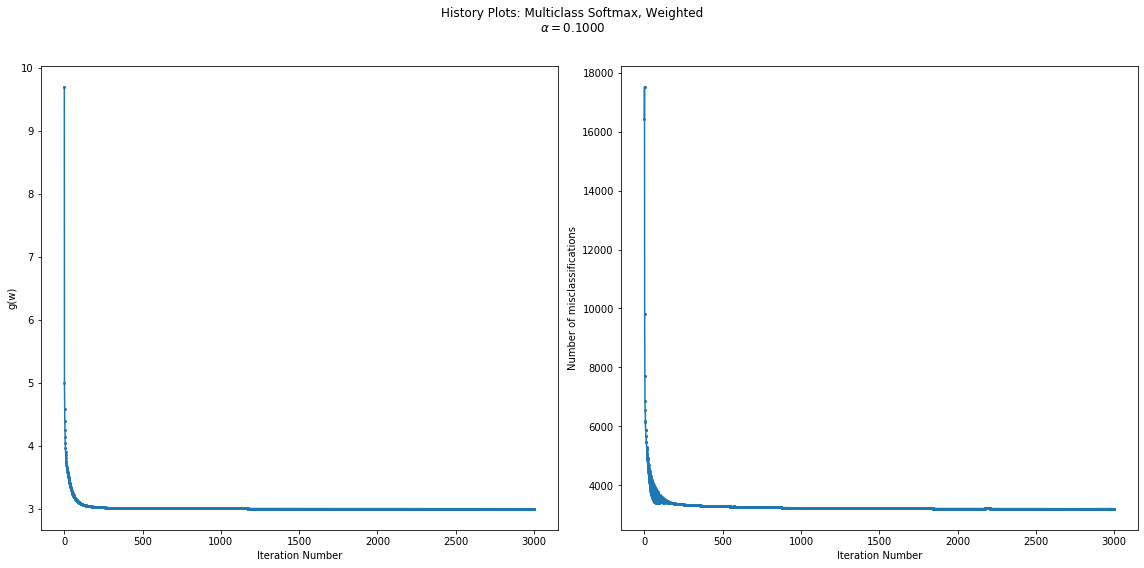

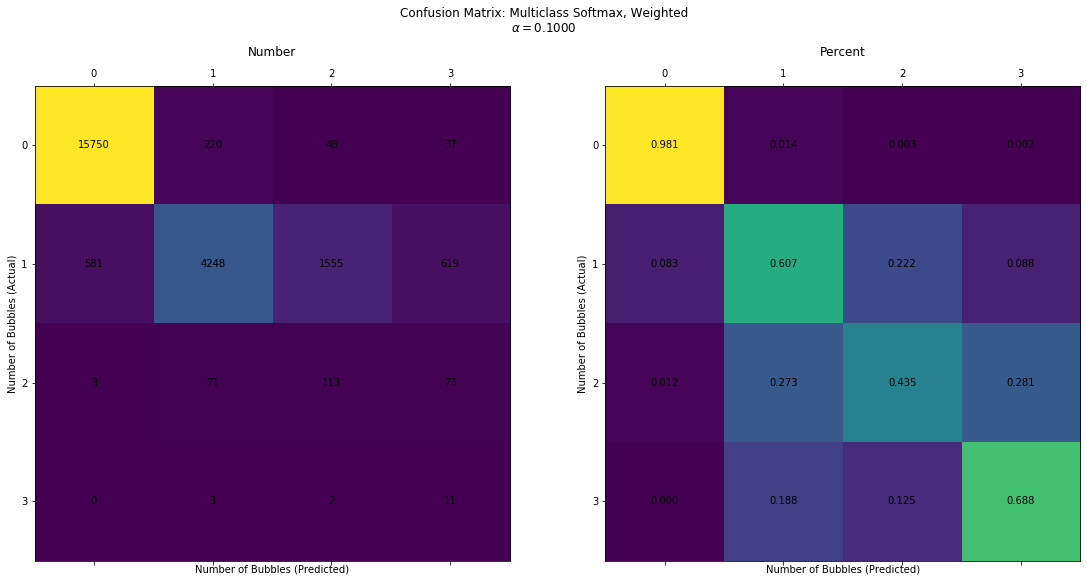

In [11]:
it_num, wh, ch, mch, bah = run_classifier(x_normed, y, cost_func="softmax", weight_by_nclass=True,
                                          alpha=0.1, iterations=3000, lam=1e-8, balanced=True)

## Determine if bubble or no bubble (2 classes)

- Only difference here is using altered y dataset and downweighting the 0 class to minimize false negatives (e.g. when there is a bubble but the classifier says there is no bubble).

Class Weights: {0: 3.114294612270321e-05, 1: 0.00013738150844896276}



Overall Accuracy: 22004/23334 = 94.3%
Balanced Accuracy: 94.6%
Accuracy in each class: [0.93827468 0.95342767]


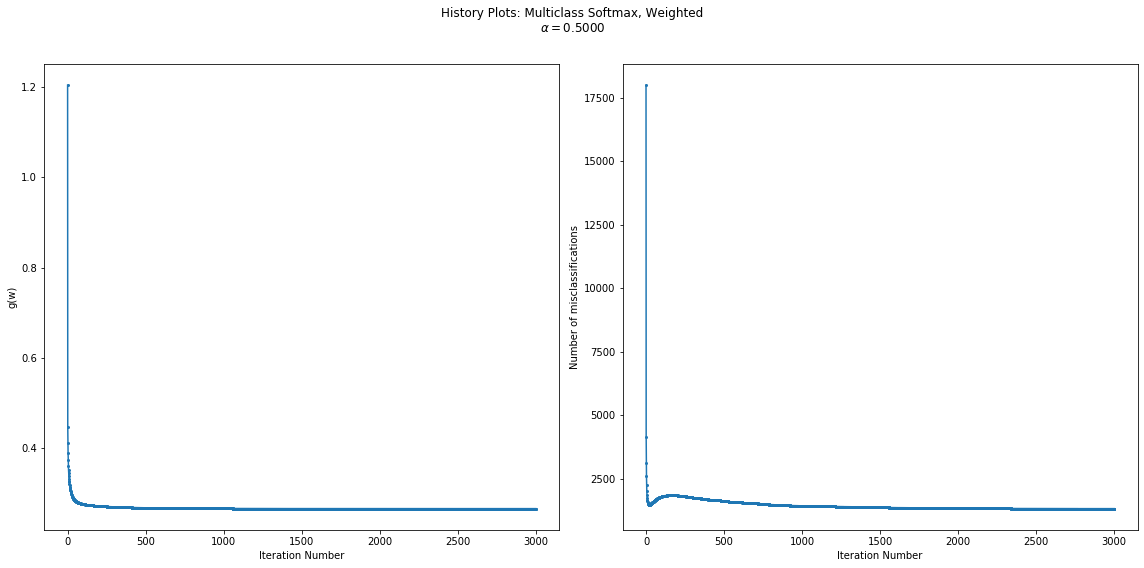

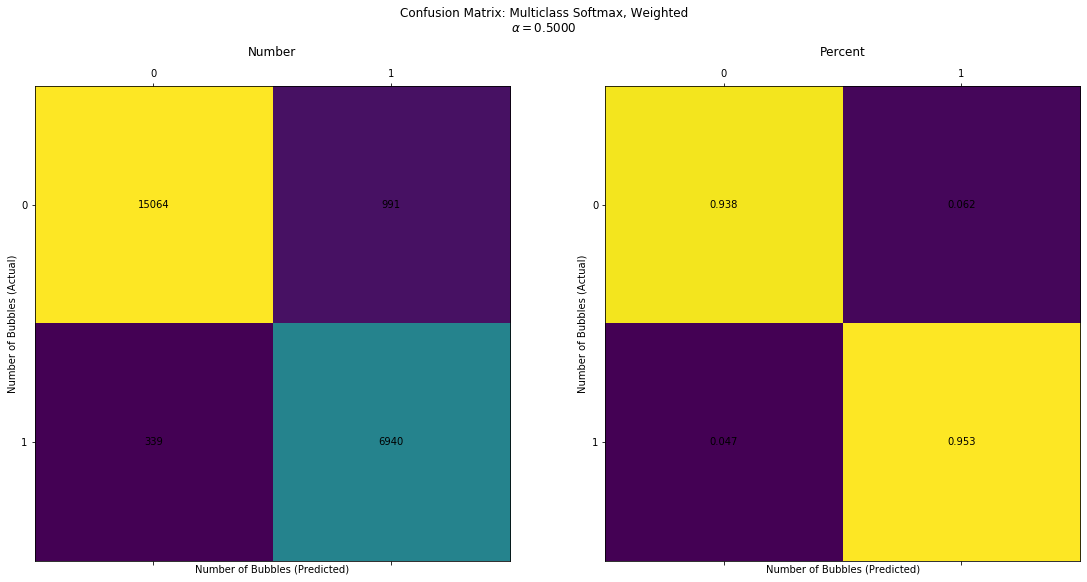

In [12]:
it_num, wh, ch, mch, bah = run_classifier(x_normed, y_2class, cost_func="softmax", weight_by_nclass=True,
                                          alpha=0.5, iterations=3000, lam=1e-5, balanced=False,
                                          n_mult={0: 2, 1: 1, 2: 1, 3: 1})

--------------